In [1]:
%matplotlib inline
import gudhi as gd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from math import exp, sin, cos, pi


import time
from tqdm.notebook import tqdm

import cubcomp
import img2perseus as i2p
from central_moment import central_moment

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

import skimage.feature as feature
from skimage.feature import greycomatrix, greycoprops

from scipy.stats import itemfreq
import cv2
from PIL import Image
from PIL import ImageEnhance

In [2]:
# Score function for topological features
# Score function for topological features
def cal_score(dim, birth, persistence, thd=0):
    if persistence < thd:
        ret = 0
    else:
        if persistence > 255:
            death = 255/256
        else:
            death = (persistence + birth)/255
            
        birth = birth/255
        ret = dim + sin(pi*(death/2)) - sin(pi*(birth/2))
                        
    return ret

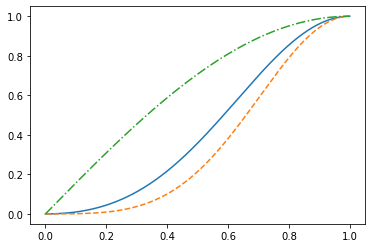

In [3]:
x = np.linspace(0, 1, 1000)
y1 = ((np.exp(np.sin(pi*x*0.5))-1)**2)/((exp(1)-1)**2)
y2 = ((np.exp(np.sin(pi*x*0.5))-1)**3)/((exp(1)-1)**3)
y3 = np.sin(pi*x*0.5)

fig, ax = plt.subplots()

ax.plot(x, y1)
ax.plot(x, y2, '--')
ax.plot(x, y3, '-.')

plt.show()

In [4]:
def sval(val):
    return ((np.exp(np.sin(pi*val*0.5))-1)**3)/((exp(1)-1)**3)

def new_score(dim, birth, persistence, thd=0):
    if persistence < thd:
        ret = 0
    else:
        if persistence > 255:
            death = 255/255
        else:
            death = (persistence + birth)/255
            
        birth = birth/255
        ret = dim + sval(death) - sval(birth)
                        
    return ret

In [5]:
def sqrt_score(dim, birth, persistence, thd=0):
    if persistence < thd:
        ret = 0
    else:
        if persistence > 255:
            death = 255/256
        else:
            death = (persistence + birth)/255
            
        birth = birth/255
        ret = 0.5*(exp(birth)+exp(death))-1
                        
    return ret

In [6]:
def count_radius(data, persist, radius=1.5):
    cnt=0
    for idx, p_data in enumerate(persist):
        dist = math.sqrt(((data[1][0]-p_data[1][0])**2)+((data[1][1]-p_data[1][1])**2))
        if data[1][1]==float('inf'):
            return 10
        if data[0]==p_data[0] and dist<=radius:
            cnt = cnt + 1
    if cnt==0: cnt=1     
    return 10/cnt

In [7]:
root_dir = 'Concrete/'
label_dir = 'steel/train.csv'

In [8]:
# load dataset from data directory
label_file = pd.read_csv(label_dir)
print(len(label_file))
label_file

7095


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


# Open First image and test it

1
3
1



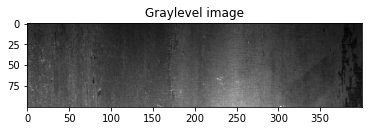

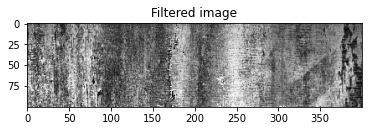

<Figure size 432x288 with 0 Axes>

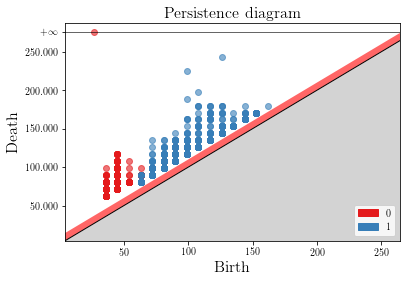

<Figure size 432x288 with 0 Axes>

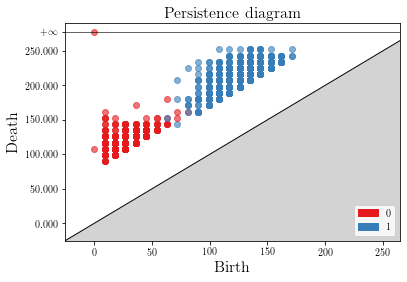

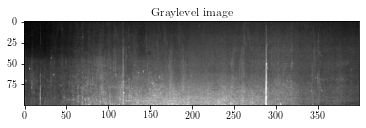

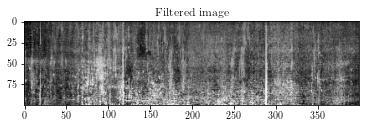

<Figure size 432x288 with 0 Axes>

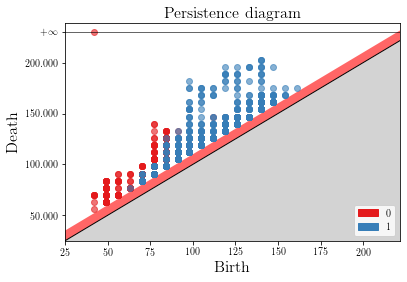

<Figure size 432x288 with 0 Axes>

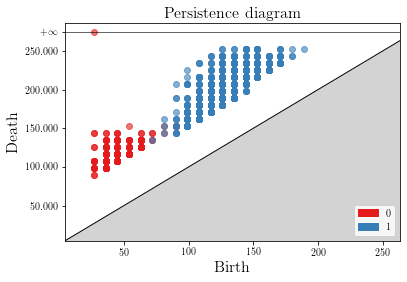

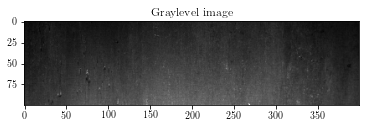

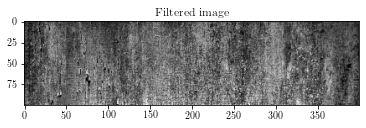

<Figure size 432x288 with 0 Axes>

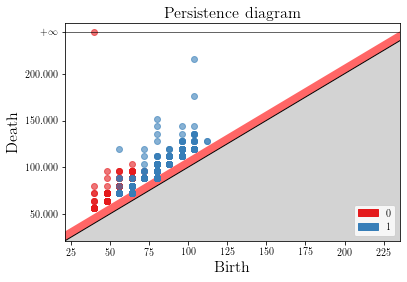

<Figure size 432x288 with 0 Axes>

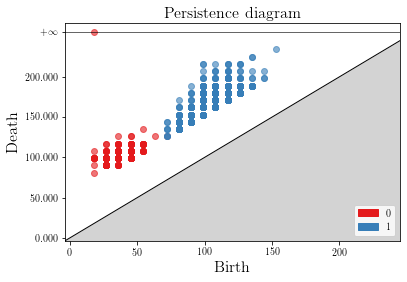

In [18]:
for idx in tqdm(range(3)):
    f_dir = root_dir + label_file['ImageId'][idx]
    label = label_file['ClassId'][idx]
    image = cv2.imread(f_dir)
    image = cv2.resize(image, dsize=(400, 100), interpolation=cv2.INTER_AREA)

    if image.shape[2]==3:
        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imGray = np.reshape(image, (image.shape[0],image.shape[1]))
    #imGray = cv2.GaussianBlur(imGray, (3,3), 0)
    
    plt.figure()
    plt.title("Graylevel image")
    plt.imshow(imGray, cmap='gray')
    plt.show        
    
    print(label)
    
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
    imFil = clahe.apply(imGray)
    imFil = i2p.imgSeg(imFil, 30)
    #imNew = cv2.cvtColor(imNew, cv2.COLOR_RGB2GRAY)
    
    plt.figure()
    plt.title("Filtered image")
    plt.imshow(imFil, cmap='gray')
    plt.show     
    '''
    plt.figure()
    plt.title("Filtered 2 image")
    plt.imshow(imSon, cmap='gray')
    plt.show 
    
    print("Label:", label)
    plt.figure()
    plt.title("Filtered image")
    plt.imshow(imFil2, cmap='gray')
    plt.show
    '''
    
    imData = i2p.imgSeg(imGray, 30)
    f_perseus = i2p.nparray2perseus(imData)
    #f_perseus = i2p.nparray2perseus(imGray)
    imGray_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    plt.figure()
    gd.plot_persistence_diagram(imGray_data, band=10, legend=True)
    plt.show
    
    f_perseus = i2p.nparray2perseus(imFil)
    imGray_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    plt.figure()
    gd.plot_persistence_diagram(imGray_data, band=0, legend=True)
    plt.show
    

In [ ]:
for idx in tqdm(range(1)):
    f_dir = root_dir + label_file['id_code'][idx] + '.png'
    label = label_file['diagnosis'][idx]
    image = cv2.imread(f_dir)

    plt.figure()
    plt.imshow(image)
    plt.show
    #print(image.shape)
    #print(image.shape[2])
    if image.shape[2]==3:
        #print("dimenstion 3")
        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        #print("dimenstion is not 3")
        imGray = np.reshape(image, (image.shape[0],image.shape[1]))
        
    imGray = cv2.resize(imGray, dsize=(150, 150), interpolation=cv2.INTER_AREA)
    
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    
    #img = Image.open(f_dir)
    imEdge = cv2.filter2D(imGray, -1, kernel)
    imEdge = cv2.edgePreservingFilter(imEdge, flags=1, sigma_s=45, sigma_r=0.2)
    #ImageEnhance.Contrast(img).enhance(0.5)
    
    #
    
    #print(imGray.shape)
    plt.figure()
    plt.title("Grayleveled image")
    plt.imshow(imGray, cmap='gray')
    plt.show
    
    plt.figure()
    plt.title("Contrast image")
    plt.imshow(imEdge, cmap='gray')
    plt.show

    f_perseus = i2p.nparray2perseus(imGray)
    imGray_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    f_perseus = i2p.nparray2perseus(imEdge)
    imEhist_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    imSeg = i2p.imgSeg(imGray, 20)
    
    f_perseus = i2p.nparray2perseus(imSeg)
    imSeg_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    plt.figure()
    plt.title("segmented image")
    plt.imshow(imSeg, cmap='gray')
    plt.show

    
    print("label:", label)
    plt.figure()
    gd.plot_persistence_diagram(imGray_data, band=30, legend=True)
    plt.show
    
    
    plt.figure()
    gd.plot_persistence_diagram(imEhist_data, band=15, legend=True)
    plt.show
    
    plt.figure()
    gd.plot_persistence_diagram(imSeg_data, band=15, legend=True)
    plt.show    

# Extract every features at once

In [ ]:
cnt = 0
thh = 10
num_score = 150
num_score2 = 300
rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)

for idx in tqdm(range(len(label_file))):
    f_dir = root_dir + label_file['image_id'][idx]
    label = label_file['label'][idx]
    try:
        open(f_dir, 'r')
    except (FileNotFoundError, FileExistsError, IsADirectoryError) as e:
        print("The file", f_dir, "is not existed")
    else:
        img = cv2.imread(f_dir)
        try:
            image = img.copy()
        except AttributeError:
            print("Nonetype error is occured")
        else:
            image = img.copy()
    
            new_row = {'img': cnt, 'label':label}
            out_dataframe = pd.DataFrame(rows)
            out_dataframe = out_dataframe.append(new_row, ignore_index=True)


            if image.shape[2]==3:
                imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                imGray = np.reshape(image, (image.shape[0],image.shape[1]))

            imGray = cv2.resize(imGray, dsize=(200, 200), interpolation=cv2.INTER_AREA)

            clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
            imFil = clahe.apply(imGray)

            #imFil = i2p.imgSeg(imFil, 15)
            f_perseus = i2p.nparray2perseus(imFil)
            cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
            p_data = cubical_complex.persistence()
            p_data.sort()

            dim0_fdata=[]
            dim1_fdata=[]
            for idx, data in enumerate(p_data):
                if data != p_data[idx-1]:
                    if data[0]==1:
                        val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                        dim1_fdata.append(val)

                    else:
                        val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                        dim0_fdata.append(val)

                dim1_fdata.sort(reverse=True)
                dim0_fdata.sort(reverse=True)

            # insert dim1 topological feature
            if num_score2 <= len(dim1_fdata):
                for i in range(0, num_score2):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])

            elif num_score2 > len(dim1_fdata):
                for i in range(0, len(dim1_fdata)):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
                for i in range(len(dim1_fdata), num_score2):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)

            # insert dim0 topological features    
            if num_score2 <= len(dim0_fdata):
                for i in range(0, num_score2):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])

            elif num_score2 > len(dim0_fdata):
                for i in range(0, len(dim0_fdata)):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
                for i in range(len(dim0_fdata), num_score2):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)

            f_perseus = i2p.nparray2perseus(imGray)
            cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
            p_data = cubical_complex.persistence()
            p_data.sort()

            dim0_data=[]
            dim1_data=[]
            for idx, data in enumerate(p_data):
                if data != p_data[idx-1]:
                    if data[0]==1:
                        val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                        dim1_data.append(val)

                    else:
                        val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                        dim0_data.append(val)

                dim1_data.sort(reverse=True)
                dim0_data.sort(reverse=True)

            # insert dim1 topological features
            if num_score <= len(dim1_data):
                for i in range(0, num_score):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])

            elif num_score > len(dim1_data):
                for i in range(0, len(dim1_data)):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
                for i in range(len(dim1_data), num_score):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), 0)

            # insert dim0 topological features    
            if num_score <= len(dim0_data):
                for i in range(0, num_score):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])

            elif num_score > len(dim0_data):
                for i in range(0, len(dim0_data)):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
                for i in range(len(dim0_data), num_score):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), 0)


            # compute local binary pattern
            #imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            radius = 6
            no_points = 2*radius

            lbp = feature.local_binary_pattern(imFil, no_points, radius, method='uniform')
            x, counts= np.unique(lbp, return_counts=True)

            for i in range(len(counts)):
                out_dataframe.insert(i+2, 'lbp_f'+str(i), counts[i])

            lbp = feature.local_binary_pattern(imGray, no_points, radius, method='uniform')    
            x, counts= np.unique(lbp, return_counts=True)

            for i in range(len(counts)):
                out_dataframe.insert(i+2, 'lbp_'+str(i), counts[i])
            
            # compute lower order histogram features
            for i in range(5):
                out_dataframe.insert(i+2, 'central_moment'+str(i+1), central_moment(imGray, order=i+1))
            
            # Compute the GLCM for original image
            distances = [1, 2, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            properties = ['energy', 'homogeneity']

            glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
            feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
            for i in range(len(feats)):
                out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

            dataframe = dataframe.append(out_dataframe, ignore_index=True)
            
            if cnt%2000 == 0 and cnt>0:
                dataframe.to_csv('csv/this_dataset'+str(cnt)+'.csv', index = False)
                dataframe = pd.DataFrame(rows)

            if cnt == len(label_file)-1:
                dataframe.to_csv('csv/this_dataset'+str(cnt)+'.csv', index = False)
                
            cnt = cnt+1
dataframe.to_csv('data_cal9.csv', index = False)

## Extract exact 512 features

In [ ]:
cnt = 0
thh = 10
num_score = 100
num_score2 = 144
rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)

for idx in tqdm(range(len(label_file))):
    f_dir = root_dir + label_file['ImageId'][idx]
    label = label_file['ClassId'][idx]
    try:
        open(f_dir, 'r')
    except (FileNotFoundError, FileExistsError, IsADirectoryError) as e:
        print("The file", f_dir, "is not existed")
    else:
        img = cv2.imread(f_dir)
        try:
            image = img.copy()
        except AttributeError:
            print("Nonetype error is occured")
        else:
            image = img.copy()
    
            new_row = {'img': cnt, 'label':label}
            out_dataframe = pd.DataFrame(rows)
            out_dataframe = out_dataframe.append(new_row, ignore_index=True)


            if image.shape[2]==3:
                imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                imGray = np.reshape(image, (image.shape[0],image.shape[1]))

            imGray = cv2.resize(imGray, dsize=(400, 100), interpolation=cv2.INTER_AREA)

            clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
            imFil = clahe.apply(imGray)

            #imFil = i2p.imgSeg(imFil, 15)
            f_perseus = i2p.nparray2perseus(imFil)
            cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
            p_data = cubical_complex.persistence()
            p_data.sort()

            dim0_fdata=[]
            dim1_fdata=[]
            for idx, data in enumerate(p_data):
                if data != p_data[idx-1]:
                    if data[0]==1:
                        val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                        dim1_fdata.append(val)

                    else:
                        val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                        dim0_fdata.append(val)

                dim1_fdata.sort(reverse=True)
                dim0_fdata.sort(reverse=True)

            # insert dim1 topological feature
            if num_score2 <= len(dim1_fdata):
                for i in range(0, num_score2):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])

            elif num_score2 > len(dim1_fdata):
                for i in range(0, len(dim1_fdata)):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
                for i in range(len(dim1_fdata), num_score2):
                    out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)

            # insert dim0 topological features    
            if num_score2 <= len(dim0_fdata):
                for i in range(0, num_score2):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])

            elif num_score2 > len(dim0_fdata):
                for i in range(0, len(dim0_fdata)):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
                for i in range(len(dim0_fdata), num_score2):
                    out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)

            f_perseus = i2p.nparray2perseus(imGray)
            cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
            p_data = cubical_complex.persistence()
            p_data.sort()

            dim0_data=[]
            dim1_data=[]
            for idx, data in enumerate(p_data):
                if data != p_data[idx-1]:
                    if data[0]==1:
                        val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                        dim1_data.append(val)

                    else:
                        val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                        dim0_data.append(val)

                dim1_data.sort(reverse=True)
                dim0_data.sort(reverse=True)

            # insert dim1 topological features
            if num_score <= len(dim1_data):
                for i in range(0, num_score):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])

            elif num_score > len(dim1_data):
                for i in range(0, len(dim1_data)):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
                for i in range(len(dim1_data), num_score):
                    out_dataframe.insert(i+2, 'dim1_'+str(i), 0)

            # insert dim0 topological features    
            if num_score <= len(dim0_data):
                for i in range(0, num_score):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])

            elif num_score > len(dim0_data):
                for i in range(0, len(dim0_data)):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
                for i in range(len(dim0_data), num_score):
                    out_dataframe.insert(i+2, 'dim0_'+str(i), 0)


            # Compute the GLCM for original image
            distances = [1, 2, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            properties = ['energy', 'homogeneity']

            glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
            feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
            for i in range(len(feats)):
                out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

            dataframe = dataframe.append(out_dataframe, ignore_index=True)
            
            #if cnt%1000 == 0 and cnt>0:
            #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)
            #    dataframe = pd.DataFrame(rows)

            #if cnt == len(label_file)-1:
            #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)
                
            cnt = cnt+1
dataframe.to_csv('512_steel_3.csv', index = False)

### For concrete dataset

In [8]:
cnt = 0
thh = 10
num_score = 100
num_score2 = 144
rows = {'img':[], 'label':[]}
root_dir = 'Concrete/'
categories = ["Negative", "Positive"]
dataframe = pd.DataFrame(rows)

for idx, categorie in enumerate(categories):
    image_dir = root_dir + categorie + '/'
    label = 0 if categorie=='Negative' else 1
    filename_in_dir = []
    for root, dirs, files in os.walk(image_dir):
        print("folder : ",categorie)
        for fname in tqdm(files):
            f_dir = image_dir+fname
            try:
                open(f_dir, 'r')
            except (FileNotFoundError, FileExistsError, IsADirectoryError) as e:
                print("The file", f_dir, "is not existed")
            else:
                img = cv2.imread(f_dir)
                try:
                    image = img.copy()
                except AttributeError:
                    print("Nonetype error is occured")
                else:
                    image = img.copy()

                    new_row = {'img': cnt, 'label':label}
                    out_dataframe = pd.DataFrame(rows)
                    out_dataframe = out_dataframe.append(new_row, ignore_index=True)


                    if image.shape[2]==3:
                        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    else:
                        imGray = np.reshape(image, (image.shape[0],image.shape[1]))

                    imGray = cv2.resize(imGray, dsize=(200, 200), interpolation=cv2.INTER_AREA)

                    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
                    imFil = clahe.apply(imGray)

                    #imFil = i2p.imgSeg(imFil, 15)
                    f_perseus = i2p.nparray2perseus(imFil)
                    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
                    p_data = cubical_complex.persistence()
                    p_data.sort()

                    dim0_fdata=[]
                    dim1_fdata=[]
                    for idx, data in enumerate(p_data):
                        if data != p_data[idx-1]:
                            if data[0]==1:
                                val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                                dim1_fdata.append(val)

                            else:
                                val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                                dim0_fdata.append(val)

                        dim1_fdata.sort(reverse=True)
                        dim0_fdata.sort(reverse=True)

                    # insert dim1 topological feature
                    if num_score2 <= len(dim1_fdata):
                        for i in range(0, num_score2):
                            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])

                    elif num_score2 > len(dim1_fdata):
                        for i in range(0, len(dim1_fdata)):
                            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
                        for i in range(len(dim1_fdata), num_score2):
                            out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)

                    # insert dim0 topological features    
                    if num_score2 <= len(dim0_fdata):
                        for i in range(0, num_score2):
                            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])

                    elif num_score2 > len(dim0_fdata):
                        for i in range(0, len(dim0_fdata)):
                            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
                        for i in range(len(dim0_fdata), num_score2):
                            out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)

                    f_perseus = i2p.nparray2perseus(imGray)
                    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
                    p_data = cubical_complex.persistence()
                    p_data.sort()

                    dim0_data=[]
                    dim1_data=[]
                    for idx, data in enumerate(p_data):
                        if data != p_data[idx-1]:
                            if data[0]==1:
                                val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                                dim1_data.append(val)

                            else:
                                val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                                dim0_data.append(val)

                        dim1_data.sort(reverse=True)
                        dim0_data.sort(reverse=True)

                    # insert dim1 topological features
                    if num_score <= len(dim1_data):
                        for i in range(0, num_score):
                            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])

                    elif num_score > len(dim1_data):
                        for i in range(0, len(dim1_data)):
                            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
                        for i in range(len(dim1_data), num_score):
                            out_dataframe.insert(i+2, 'dim1_'+str(i), 0)

                    # insert dim0 topological features    
                    if num_score <= len(dim0_data):
                        for i in range(0, num_score):
                            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])

                    elif num_score > len(dim0_data):
                        for i in range(0, len(dim0_data)):
                            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
                        for i in range(len(dim0_data), num_score):
                            out_dataframe.insert(i+2, 'dim0_'+str(i), 0)


                    # Compute the GLCM for original image
                    distances = [1, 2, 3]
                    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
                    properties = ['energy', 'homogeneity']

                    glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
                    feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
                    for i in range(len(feats)):
                        out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

                    dataframe = dataframe.append(out_dataframe, ignore_index=True)

                    #if cnt%1000 == 0 and cnt>0:
                    #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)
                    #    dataframe = pd.DataFrame(rows)

                    #if cnt == len(label_file)-1:
                    #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)

                    cnt = cnt+1
dataframe.to_csv('512_concrete.csv', index = False)

folder :  Negative



folder :  Positive


### Colorectal histology dataset

In [9]:
data_set = tfds.load(name="colorectal_histology", split='train')

4



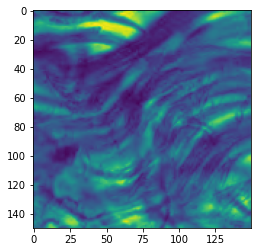

In [27]:
for data in tqdm(data_set.take(1)):
    image, label = data['image'], data['label']
    image = image.numpy()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    print(label.numpy())

In [30]:
cnt = 0
thh = 10
num_score = 100
num_score2 = 144
rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)
#len(data_set)
for data in tqdm(data_set.take(len(data_set))):
    image, label = data['image'], data['label'].numpy()
    
    #image = img.copy()
    image = image.numpy()
    new_row = {'img': cnt, 'label':label}
    out_dataframe = pd.DataFrame(rows)
    out_dataframe = out_dataframe.append(new_row, ignore_index=True)


    if image.ndim == 3:
        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imGray = np.reshape(image, (image.shape[0],image.shape[1]))

    imGray = cv2.resize(imGray, dsize=(200, 200), interpolation=cv2.INTER_AREA)

    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
    imFil = clahe.apply(imGray)

    #imFil = i2p.imgSeg(imFil, 15)
    f_perseus = i2p.nparray2perseus(imFil)
    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
    p_data = cubical_complex.persistence()
    p_data.sort()

    dim0_fdata=[]
    dim1_fdata=[]
    for idx, data in enumerate(p_data):
        if data != p_data[idx-1]:
            if data[0]==1:
                val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                dim1_fdata.append(val)

            else:
                val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                dim0_fdata.append(val)

        dim1_fdata.sort(reverse=True)
        dim0_fdata.sort(reverse=True)

    # insert dim1 topological feature
    if num_score2 <= len(dim1_fdata):
        for i in range(0, num_score2):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])

    elif num_score2 > len(dim1_fdata):
        for i in range(0, len(dim1_fdata)):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
        for i in range(len(dim1_fdata), num_score2):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)

    # insert dim0 topological features    
    if num_score2 <= len(dim0_fdata):
        for i in range(0, num_score2):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])

    elif num_score2 > len(dim0_fdata):
        for i in range(0, len(dim0_fdata)):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
        for i in range(len(dim0_fdata), num_score2):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)

    f_perseus = i2p.nparray2perseus(imGray)
    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
    p_data = cubical_complex.persistence()
    p_data.sort()

    dim0_data=[]
    dim1_data=[]
    for idx, data in enumerate(p_data):
        if data != p_data[idx-1]:
            if data[0]==1:
                val=new_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                dim1_data.append(val)

            else:
                val=new_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*p_data.count(data)
                dim0_data.append(val)

        dim1_data.sort(reverse=True)
        dim0_data.sort(reverse=True)

    # insert dim1 topological features
    if num_score <= len(dim1_data):
        for i in range(0, num_score):
            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])

    elif num_score > len(dim1_data):
        for i in range(0, len(dim1_data)):
            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
        for i in range(len(dim1_data), num_score):
            out_dataframe.insert(i+2, 'dim1_'+str(i), 0)

    # insert dim0 topological features    
    if num_score <= len(dim0_data):
        for i in range(0, num_score):
            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])

    elif num_score > len(dim0_data):
        for i in range(0, len(dim0_data)):
            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
        for i in range(len(dim0_data), num_score):
            out_dataframe.insert(i+2, 'dim0_'+str(i), 0)


    # Compute the GLCM for original image
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['energy', 'homogeneity']

    glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
    feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
    for i in range(len(feats)):
        out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

    dataframe = dataframe.append(out_dataframe, ignore_index=True)
            
            #if cnt%1000 == 0 and cnt>0:
            #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)
            #    dataframe = pd.DataFrame(rows)

            #if cnt == len(label_file)-1:
            #    dataframe.to_csv('csv/steel_'+str(cnt)+'.csv', index = False)
                
    cnt = cnt+1
dataframe.to_csv('512_colorectal.csv', index = False)

In [31]:
out_file = pd.read_csv('512_colorectal.csv')
out_file

,img,label,glcm1,glcm2,glcm3,glcm4,glcm5,glcm6,glcm7,glcm8,...,dim1_f134,dim1_f135,dim1_f136,dim1_f137,dim1_f138,dim1_f139,dim1_f140,dim1_f141,dim1_f142,dim1_f143
0,0.0,4.0,0.025649,0.018881,0.022185,0.021609,0.019009,0.018881,0.016464,0.021609,...,1.144119,1.144055,1.141462,1.140890,1.140496,1.139505,1.138755,1.138495,1.138295,1.137700
1,1.0,5.0,0.014140,0.012114,0.014769,0.012629,0.010724,0.012114,0.011029,0.012629,...,1.173773,1.172292,1.172241,1.171061,1.169534,1.165232,1.164603,1.161667,1.161359,1.160668
2,2.0,5.0,0.021788,0.018694,0.022960,0.019396,0.016530,0.018694,0.017256,0.019396,...,1.279853,1.279428,1.278990,1.278840,1.276803,1.271004,1.269298,1.267206,1.265393,1.265125
3,3.0,0.0,0.023829,0.020803,0.025408,0.021172,0.018125,0.020803,0.019116,0.021172,...,1.350864,1.346319,1.346264,1.346063,1.346044,1.344880,1.344845,1.342916,1.340594,1.339643
4,4.0,6.0,0.225856,0.197577,0.218143,0.196796,0.190692,0.197577,0.181290,0.196796,...,1.043963,1.043337,1.042333,1.042171,1.041915,1.041883,1.041644,1.040826,1.039771,1.039694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995.0,7.0,0.414698,0.373542,0.403183,0.373698,0.366950,0.373542,0.352826,0.373698,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4996,4996.0,1.0,0.017857,0.015234,0.019934,0.017246,0.013820,0.015234,0.015170,0.017246,...,1.326591,1.325274,1.324939,1.324911,1.322145,1.318947,1.317641,1.317331,1.309724,1.307490
4997,4997.0,5.0,0.013634,0.011946,0.013963,0.011676,0.010312,0.011946,0.010512,0.011676,...,1.175463,1.173663,1.171693,1.171567,1.170419,1.170048,1.167212,1.164859,1.161124,1.160245
4998,4998.0,4.0,0.021654,0.016790,0.018977,0.017302,0.016366,0.016790,0.014455,0.017302,...,1.323389,1.322879,1.321595,1.321363,1.316952,1.316751,1.316726,1.316000,1.312922,1.304848


## Extract persistent data weighted by radius

In [7]:
cnt = 0
thh = 10
num_score = 150
num_score2 = 300
rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)

for idx in tqdm(range(len(label_file))):
    f_dir = root_dir + label_file['ImageId'][idx]
    label = label_file['ClassId'][idx] - 1
    img = cv2.imread(f_dir)
    image = img.copy()
    #image = cv2.resize(image, (200,200))
    
    new_row = {'img': cnt, 'label':label}
    out_dataframe = pd.DataFrame(rows)
    out_dataframe = out_dataframe.append(new_row, ignore_index=True)
    
    
    if image.shape[2]==3:
        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imGray = np.reshape(image, (image.shape[0],image.shape[1]))

    imGray = cv2.resize(imGray, dsize=(400, 100), interpolation=cv2.INTER_AREA)
    #imGray = cv2.GaussianBlur(imGray, (3,3), 0)
    
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
    imFil = clahe.apply(imGray)
        
    #imFil = i2p.imgSeg(imFil, 15)
    f_perseus = i2p.nparray2perseus(imFil)
    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
    p_data = cubical_complex.persistence()
    p_data.sort()
    
    dim0_fdata=[]
    dim1_fdata=[]
    for idx, data in enumerate(p_data):
        if data != p_data[idx-1]:
            if data[0]==1:
                val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*count_radius(data, p_data)
                dim1_fdata.append(val)

            else:
                val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*count_radius(data, p_data)
                dim0_fdata.append(val)
            
        dim1_fdata.sort(reverse=True)
        dim0_fdata.sort(reverse=True)
    
    # insert dim1 topological feature
    if num_score2 <= len(dim1_fdata):
        for i in range(0, num_score2):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
            
    elif num_score2 > len(dim1_fdata):
        for i in range(0, len(dim1_fdata)):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
        for i in range(len(dim1_fdata), num_score2):
            out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)
            
    # insert dim0 topological features    
    if num_score2 <= len(dim0_fdata):
        for i in range(0, num_score2):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
            
    elif num_score2 > len(dim0_fdata):
        for i in range(0, len(dim0_fdata)):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
        for i in range(len(dim0_fdata), num_score2):
            out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)
    
    imData = i2p.imgSeg(imGray, 30)
    f_perseus = i2p.nparray2perseus(imGray)
    cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
    p_data = cubical_complex.persistence()
    p_data.sort()
    
    dim0_data=[]
    dim1_data=[]
    for idx, data in enumerate(p_data):
        if data != p_data[idx-1]:
            if data[0]==1:
                val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)#*count_radius(data, p_data)
                dim1_data.append(val)

            else:
                val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)#*count_radius(data, p_data)
                dim0_data.append(val)
            
        dim1_data.sort(reverse=True)
        dim0_data.sort(reverse=True)
    
    # insert dim1 topological features
    if num_score <= len(dim1_data):
        for i in range(0, num_score):
            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
            
    elif num_score > len(dim1_data):
        for i in range(0, len(dim1_data)):
            out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
        for i in range(len(dim1_data), num_score):
            out_dataframe.insert(i+2, 'dim1_'+str(i), 0)
            
    # insert dim0 topological features    
    if num_score <= len(dim0_data):
        for i in range(0, num_score):
            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
            
    elif num_score > len(dim0_data):
        for i in range(0, len(dim0_data)):
            out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
        for i in range(len(dim0_data), num_score):
            out_dataframe.insert(i+2, 'dim0_'+str(i), 0)
            
    # compute local binary pattern
    #imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    radius = 6
    no_points = 2*radius
    
    lbp = feature.local_binary_pattern(imGray, no_points, radius, method='uniform')    
    x, counts= np.unique(lbp, return_counts=True)
    
    for i in range(len(counts)):
        out_dataframe.insert(i+2, 'lbp_'+str(i), counts[i])
    
    # compute lower order histogram features
    for i in range(5):
        out_dataframe.insert(i+2, 'central_moment'+str(i+1), central_moment(imGray, order=i+1))
    
    # Compute the GLCM for original image
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['energy', 'homogeneity']

    glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
    feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
    for i in range(len(feats)):
        out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

    dataframe = dataframe.append(out_dataframe, ignore_index=True)
    
    
    if cnt%300 == 0 and cnt>0:
        dataframe.to_csv('steel/csv/this_dataset'+str(cnt)+'.csv', index = False)
        dataframe = pd.DataFrame(rows)

    if cnt == len(label_file)-1:
        dataframe.to_csv('steel/csv/this_dataset'+str(cnt)+'.csv', index = False)
    cnt = cnt+1
#dataframe.to_csv('data_steel.csv', index = False)

In [ ]:
thh = 30
num_score = 200
rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)

temp_rows = {'dim':[], 'birth':[], 'persistence':[]}
temp_dataframe = pd.DataFrame(temp_rows)

for idx in tqdm(range(len(label_file))):
    f_dir = root_dir + label_file['Filename'][idx]
    label = label_file['Label'][idx]
    image = cv2.imread(f_dir)
    
    new_row = {'img': label_file['Filename'][idx], 'label':label}
    out_dataframe = pd.DataFrame(rows)
    out_dataframe = out_dataframe.append(new_row, ignore_index=True)
    
    imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imGray_seg = i2p.imgSeg(imGray, 10)

    
    
    # compute local binary pattern

    radius = 6
    no_points = 2*radius
    #lbp = feature.local_binary_pattern(imGray, no_points, radius, method='uniform')
    lbp = feature.local_binary_pattern(imGray_seg, no_points, radius, method='uniform')
    x, counts= np.unique(lbp, return_counts=True)
    #hist = counts[:]/sum(counts[:])
    #문제발생
    #hist = x[:]/sum(x[:])
    
    for i in range(len(counts)):
        out_dataframe.insert(i+2, 'hist_'+str(i), counts[i])

        
    dataframe = dataframe.append(out_dataframe, ignore_index=True)
    
dataframe.to_csv('lbp_dataset_38.csv', index = False)

In [ ]:
cnt = 0
thh = 10
num_score = 100


for idx in tqdm(range(32, 33)):
    f_dir = root_dir + label_file['id_code'][idx] + '.png'
    label = label_file['diagnosis'][idx]
    img = cv2.imread(f_dir)
    image = img.copy()
    #image = cv2.resize(image, (200,200))
    
    
    if image.shape[2]==3:
        imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imGray = np.reshape(image, (image.shape[0],image.shape[1]))

    imGray = cv2.resize(imGray, dsize=(150, 150), interpolation=cv2.INTER_AREA)
    
    f_perseus = i2p.nparray2perseus(imGray)
    imGray_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    plt.figure()
    gd.plot_persistence_diagram(imGray_data, band=30, legend=True)
    plt.show
    
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
    imGray = clahe.apply(imGray)
        
    plt.figure()
    plt.imshow(imGray, cmap='gray')
    plt.show
    
    f_perseus = i2p.nparray2perseus(imGray)
    imGray_data = gd.CubicalComplex(perseus_file = f_perseus).persistence()
    
    plt.figure()
    gd.plot_persistence_diagram(imGray_data, band=30, legend=True)
    plt.show

In [ ]:
imGray_data.sort()
imGray_data

In [ ]:
for idx, data in enumerate(imGray_data):
    #print(idx, data)
    if data != imGray_data[idx-1]:
        print(cal_score(data[0], data[1][0], data[1][1]-data[1][0], thd=0)*imGray_data.count(data))
    else:
        print(0)
        
print(lst)

# Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
save_dir = 'agumented_data/'

image_generator = ImageDataGenerator(
    rotation_range = 60,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range=0.2,
    zoom_range = 0.25,
    horizontal_flip=True,
    fill_mode = 'nearest',
)

for idx in tqdm(range(len(label_file))):
    f_dir = root_dir + label_file['id_code'][idx] + '.png'
    label = label_file['diagnosis'][idx]
    if label != 0:
        img = cv2.imread(f_dir)
        image = img.copy()

        x = img_to_array(image)
        x = x.reshape((1,)+x.shape)
        
        if label == 1:
            num_aug = 3
        elif label ==2:
            num_aug = 0
        elif label == 3:
            num_aug = 7
        else:
            num_aug = 4
            
        i = 0
        for batch in image_generator.flow(x, batch_size=1, save_to_dir=save_dir+str(label), save_prefix='ag_', save_format='png'):
            i=i+1
            if i > num_aug:
                break

In [ ]:
cnt = 0
thh = 10
num_score = 150
num_score2 = 300

rows = {'img':[], 'label':[]}
dataframe = pd.DataFrame(rows)
save_dir = 'agumented_data/'

for label in range(5):
    file_list = os.listdir(save_dir+str(label))
    print("Folder ", save_dir+str(label) , "is operating...")
    for file in tqdm(file_list):
        f_dir = save_dir+str(label)+'/'+str(file)
        try:
            open(f_dir, 'r')
        except (FileNotFoundError, FileExistsError, IsADirectoryError) as e:
            print("The file", f_dir, "is not existed")
        else:
            img = cv2.imread(f_dir)
            try:
                image = img.copy()
            except AttributeError:
                print("Nonetype error is occured")
            else:
                image = img.copy()
                #image = cv2.resize(image, (200,200))

                new_row = {'img': cnt, 'label':label}
                out_dataframe = pd.DataFrame(rows)
                out_dataframe = out_dataframe.append(new_row, ignore_index=True)


                if image.shape[2]==3:
                    imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                else:
                    imGray = np.reshape(image, (image.shape[0],image.shape[1]))

                imGray = cv2.resize(imGray, dsize=(200, 200), interpolation=cv2.INTER_AREA)

                clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
                imFil = clahe.apply(imGray)

                f_perseus = i2p.nparray2perseus(imFil)
                cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
                p_data = cubical_complex.persistence()
                p_data.sort()

                dim0_fdata=[]
                dim1_fdata=[]
                for idx, data in enumerate(p_data):
                    if data != p_data[idx-1]:
                        if data[0]==1:
                            val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                            dim1_fdata.append(val)

                        else:
                            val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                            dim0_fdata.append(val)

                    dim1_fdata.sort(reverse=True)
                    dim0_fdata.sort(reverse=True)

                # insert dim1 topological feature
                if num_score2 <= len(dim1_fdata):
                    for i in range(0, num_score2):
                        out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])

                elif num_score2 > len(dim1_fdata):
                    for i in range(0, len(dim1_fdata)):
                        out_dataframe.insert(i+2, 'dim1_f'+str(i), dim1_fdata[i])
                    for i in range(len(dim1_fdata), num_score2):
                        out_dataframe.insert(i+2, 'dim1_f'+str(i), 0)

                # insert dim0 topological features    
                if num_score2 <= len(dim0_fdata):
                    for i in range(0, num_score2):
                        out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])

                elif num_score2 > len(dim0_fdata):
                    for i in range(0, len(dim0_fdata)):
                        out_dataframe.insert(i+2, 'dim0_f'+str(i), dim0_fdata[i])
                    for i in range(len(dim0_fdata), num_score2):
                        out_dataframe.insert(i+2, 'dim0_f'+str(i), 0)

                f_perseus = i2p.nparray2perseus(imGray)
                cubical_complex = gd.CubicalComplex(perseus_file = f_perseus)
                p_data = cubical_complex.persistence()
                p_data.sort()

                dim0_data=[]
                dim1_data=[]
                for idx, data in enumerate(p_data):
                    if data != p_data[idx-1]:
                        if data[0]==1:
                            val=cal_score(1, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                            dim1_data.append(val)

                        else:
                            val=cal_score(0, data[1][0], data[1][1]-data[1][0], thd=thh)*p_data.count(data)
                            dim0_data.append(val)

                    dim1_data.sort(reverse=True)
                    dim0_data.sort(reverse=True)

                # insert dim1 topological features
                if num_score <= len(dim1_data):
                    for i in range(0, num_score):
                        out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])

                elif num_score > len(dim1_data):
                    for i in range(0, len(dim1_data)):
                        out_dataframe.insert(i+2, 'dim1_'+str(i), dim1_data[i])
                    for i in range(len(dim1_data), num_score):
                        out_dataframe.insert(i+2, 'dim1_'+str(i), 0)

                # insert dim0 topological features    
                if num_score <= len(dim0_data):
                    for i in range(0, num_score):
                        out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])

                elif num_score > len(dim0_data):
                    for i in range(0, len(dim0_data)):
                        out_dataframe.insert(i+2, 'dim0_'+str(i), dim0_data[i])
                    for i in range(len(dim0_data), num_score):
                        out_dataframe.insert(i+2, 'dim0_'+str(i), 0)


                # compute local binary pattern
                #imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                radius = 6
                no_points = 2*radius

                lbp = feature.local_binary_pattern(imFil, no_points, radius, method='uniform')
                x, counts= np.unique(lbp, return_counts=True)

                for i in range(len(counts)):
                    out_dataframe.insert(i+2, 'lbp_f'+str(i), counts[i])

                lbp = feature.local_binary_pattern(imGray, no_points, radius, method='uniform')    
                x, counts= np.unique(lbp, return_counts=True)

                for i in range(len(counts)):
                    out_dataframe.insert(i+2, 'lbp_'+str(i), counts[i])

                # compute lower order histogram features
                for i in range(5):
                    out_dataframe.insert(i+2, 'central_moment'+str(i+1), central_moment(imGray, order=i+1))
                
                # Compute the GLCM for original image
                distances = [1, 2, 3]
                angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
                properties = ['energy', 'homogeneity']

                glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
                feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
                for i in range(len(feats)):
                    out_dataframe.insert(i+2, 'glcm'+str(i+1), feats[i])

                dataframe = dataframe.append(out_dataframe, ignore_index=True)

        cnt = cnt+1
    dataframe.to_csv('data_cal8_aug.csv', index = False)

In [ ]:


for idx in tqdm(range(1)):
    f_dir = root_dir + label_file['id_code'][idx] + '.png'
    label = label_file['diagnosis'][idx]
    image = cv2.imread(f_dir)
    imGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['energy', 'homogeneity']
    
    glcm = greycomatrix(imGray, distances=distances, angles=angles, symmetric=True, normed=True)
    
    feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
    
print(feats)